# Contents

1. [Introduction](#intro)
2. [Analysis of embeddings](#analysis)
3. [Logistic Model](#logistic_model)
4. [PCA Plot](#pca1)
5. [Cosine Similarity](#cosine)
6. [Clustering](#clustering)
7. [More models](#more_models)

---

# Using topic change as prediction <a id='intro'></a>

As mentioned earlier, the EDA/more basic models found that when someone is condescending, the topic of the conversation will change. Maybe we can use this to identify people who are condescending.

For this, we will need to figure out the topic of the conversation, which is a bit difficult since it isn't labelled.

## What is a sentence embedding?
A word embedding is the meaning of a word, converted into a vector. So something like 'dog' and 'cat' would have somewhat similar embeddings. We can also do things like 'dog' + 'young' -> 'puppy' by adding the vectors.

Similarly, a sentence embedding is the meaning of an entire sentence converted into a vector. So if someone says 'you are an idiot' the embedding would be similar to 'please get an education' even though the words are completely different.


## Why do I want to look at this?
Earlier we established that when someone is condescending, the reply will usually be 
- Strong language
- Saying something about the original post.

These are clearly a change in topic so let's see if we can spot any changes.

## How does BERT factor into this?
There are about 5000 rows of data, and there are lots and lots of possible topics. There is no way I could manually label these by hand and even if I did, it wouldn't be accurate. However, BERT can classify a sentence into one of about 760 different categories. I will use this on each post (and each reply) and see how the topics change.

Note that I'm just using BERT to figure out the topic and not training anything. This is why I didn't split into train/test as I am just looking.

It also assumes BERT is accurate, which is hopefully a reasonable assumption.

## How to use BERT?
A library called Transformers has pretrained BERT models so I just loaded one of them in.

In [9]:
# Since I'm not training BERT this should be quite fast, and simple to do (I hope!)

# import
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertModel

import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

To use BERT I need to tokenize the words but the library has an easy to use version.

In [2]:
# load model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [10]:
# read in data
cond_df = pd.read_csv("./cond_data/added_features/balanced_train_more_features.csv")
cond_df.drop("Unnamed: 0", axis = 1, inplace=True)
cond_df.head(3)

,quotedpost,quotedreply,label,post,reply,post_user,reply_user,start_offset,end_offset,reddit_post_id,reddit_reply_id,has_cond,post_len,reply_len,cleaned_post,cleaned_reply
0,Please educate yoyrself before you bring your ...,"Not condescending at all, jeez.",True,"Well a guy is saying Barra, who has those grea...",> Please educate yoyrself before you bring you...,StalinHimself,Kel_Casus,135,208,dbl4vl9,dblfraj,1,37,17,"Well a guy is saying Barra, who has those grea...","Not condescending at all, jeez."
1,There might be some small piece that's incorrect,You said that. Not me. Not James-Cizuz. You sa...,True,> I think you're the one who has a reading com...,> theories are constantly growing and evolving...,kishi,jids,365,413,c2dtpq9,c2dtywp,1,314,230,"Well you're a stupid poopy-head.\n\nSee, I don...",Why would theories self-correct if they were a...
2,If I try and force down a breakfast I start ga...,Yes!\n\nPeople were so condescending about it ...,False,For me it's like temporarily having the flu. T...,> If I try and force down a breakfast I start ...,amphetaminesfailure,CowGiraffe,331,383,cuv97mf,cuvnb27,1,107,179,For me it's like temporarily having the flu. T...,Yes!\n\nPeople were so condescending about it ...


The way that BERT works is a bit complicated so I won't go through it here. The important part that we need to know is that when you put in some text, it returns a vector of size 768 (among other things), and each item in the vector is one of the categories for the sentence embeddings.

In [8]:
# This is how to do one sentence
# i = 4
# post = cond_df.iloc[i, 14] #example post, could just be text like "hello there"

# post_input = torch.tensor(tokenizer.encode(post)).unsqueeze(0)
# outputs = model(post_input)

# outputs[0][0][0].detach().numpy()

This takes one block of text and returns the sentence embeddings.

Since BERT only works with text up to length 512 I used a moving window (with 50 overlap) and just took the average of the windows. This method is from [here](#https://medium.com/analytics-vidhya/text-classification-with-bert-using-transformers-for-long-text-inputs-f54833994dfd).

Note that since Transformers is based on Pytorch you could probably put everything in at once however I was having a lot of trouble figuring that part out, so I just did it one by one in a for loop (easier to test and fix errors).

In [64]:
# Takes text and returns the 768 size embedding vector
# If text is > 512 (max bert size) it uses a moving window,
# then it just takes the average

def sentence_embedding(text):
    
    # encode with tokenizer
    # put into a list (if len > 512 it's a list so I just want to keep it consistent)
    tokenized_text = [tokenizer.encode(text)]
    
    # note: it can only be 512 or less. This is a problem since some posts are really long
    # The solution, per https://medium.com/analytics-vidhya/text-classification-with-bert-using-transformers-for-long-text-inputs-f54833994dfd
    # is to put in only 512, but with an overlap of 50 words.

    
    if len(tokenized_text[0]) > 512:
        # put into list of lists
        # the name could be better I guess
        text_encoded_list = []
        
        start_pos = 0
        end_pos = 512
        
        break_on_next_loop = False
        
        while 1:
            text_encoded_list.append(tokenized_text[0][start_pos:end_pos])
            
            if break_on_next_loop:
                break
        
            # we are basically moving by 512 - 50 = 462 steps each time
            end_pos += 462
            if end_pos > len(tokenized_text[0]):
                end_pos = len(tokenized_text[0])                
                break_on_next_loop = True
                
            # then determine the start
            start_pos = end_pos - 512
            
        # just put it in the original variable
        tokenized_text = text_encoded_list
    
    all_embeddings = []
    
    for tokenized_512_len in tokenized_text:
        
        # put into model
        # then get vector (this is the [0][0][0] part, since we only want the category)
        # then convert to numpy via .detach().numpy()
        all_embeddings.append(
            model(torch.tensor(tokenized_512_len).unsqueeze(0))[0][0][0].detach().numpy()
        )
        
    # then return the average of all embeddings
    return np.mean(np.array(all_embeddings), axis = 0)



Now just get the embeddings of all the posts and replies:

In [66]:
%%time

# Loop through all the (cleaned) posts/replies of the dataframe

post_embedding = []
reply_embedding = []

num_rows = cond_df.shape[0]

# change this to true to get the embeddings
run_this_block = False

if run_this_block == True:
    for index, row in cond_df.iterrows():
        if index %%10 == 0:
            print("{}/{}".format(index, num_rows))

        # get the sentence embedding of the post
        post_text = row["cleaned_post"]
        post_embedding.append(sentence_embedding(post_text))

        # and of the reply
        reply_text = row["cleaned_reply"]
        reply_embedding.append(sentence_embedding(reply_text))

    print("done")

done
Wall time: 48min 54s


In [70]:
# convert to dataframme
post_embeddings_df = pd.DataFrame(post_embedding)
reply_embeddings_df = pd.DataFrame(reply_embedding)

I don't want to run this every time so save the data.

In [71]:
# Uncomment to save
#post_embeddings_df.to_csv("./cond_data/bert_sentence_embeddings/post_embeddings.csv")
#reply_embeddings_df.to_csv("./cond_data/bert_sentence_embeddings/reply_embeddings.csv")

print("done")

At this point, we have converted every post and every reply to a sentence embedding which hopefully contains some information about the sentiment of the post/reply. There are 767 categories, of course most of them should be near zero so we will need to use some kind of analysis method to figure this out.

# Analysis of Sentence Embeddings: <a id='analysis'></a>
I wasn't able to find what these 760 odd categories actually mean. As in, what does a specific element in the vector represent?

However I can still do analysis on these categories.

In [11]:
# Load in the data, again
post_embeddings_df = pd.read_csv("./cond_data/bert_sentence_embeddings/post_embeddings.csv")
reply_embeddings_df = pd.read_csv("./cond_data/bert_sentence_embeddings/reply_embeddings.csv")

post_embeddings_df.drop("Unnamed: 0", axis = 1, inplace = True)
reply_embeddings_df.drop("Unnamed: 0", axis = 1, inplace = True)

As much as a heatmap would be nice here, there are 768 columns so that's a bit much. Mostly, I just want to find if there are any categories that are strongly correlated with condescending posts.

Therefore, I used the point biserial correlation, which determines the correlation between a boolean var (condescending vs not) and a continuous variable (BERT's predictions for one category of embedding/topic)

I don't actually know *what* each feature means, just that it is some kind of category that the sentence could be in. For example a feature could be 'person is asking for something' and the values in it represent how likely the model thinks that the user is asking for a thing.

With that in mind I just took the absolute value of the correlation. It's easier to sort. Also, if the p-value was larger than 0.05 we can't disprove the null hypothesis, so I just put the correlation back to 0.

In [12]:
from scipy.stats import pointbiserialr

In [5]:
biserial_correlations = []

# loop through all the columns
for col_index in range(post_embeddings_df.shape[1]):
    # get the correlation between condescenscion and sentence embedding for the post
    post_corr, post_pval = pointbiserialr(cond_df["label"], post_embeddings_df.iloc[:,col_index])
    
    # if pval is too high then we can't actually say anything
    if post_pval > 0.05:
        post_corr = 0
    
    # same for the reply
    reply_corr, reply_pval = pointbiserialr(cond_df["label"], reply_embeddings_df.iloc[:, col_index])
    
    # same thing here, check the p value
    if reply_pval > 0.05:
        reply_corr = 0
    
    # put it into a list
    biserial_correlations.append([col_index, np.abs(post_corr), post_pval, np.abs(reply_corr), reply_pval])

In [6]:
biserial_correlations = pd.DataFrame(biserial_correlations, columns = ["embed_category",
                                                                       "post_corr",
                                                                       "post_pval",
                                                                       "reply_corr",
                                                                       "reply_pval"])

In [7]:
biserial_correlations.sort_values(by = "post_corr", ascending=False)

,embed_category,post_corr,post_pval,reply_corr,reply_pval
307,307,0.188785,5.501549e-43,0.307561,1.654764e-114
438,438,0.187957,1.281511e-42,0.308565,2.783010e-115
489,489,0.186464,5.835309e-42,0.228298,1.488284e-62
179,179,0.184387,4.705180e-41,0.271961,5.516423e-89
643,643,0.182884,2.100165e-40,0.251451,6.385868e-76
...,...,...,...,...,...
511,511,0.000000,4.252413e-01,0.102985,9.325641e-14
510,510,0.000000,5.341367e-01,0.000000,2.547746e-01
166,166,0.000000,9.488803e-02,0.031814,2.168093e-02
503,503,0.000000,3.442432e-01,0.034061,1.396379e-02


We were able to get the correlations, so now just make a chart.

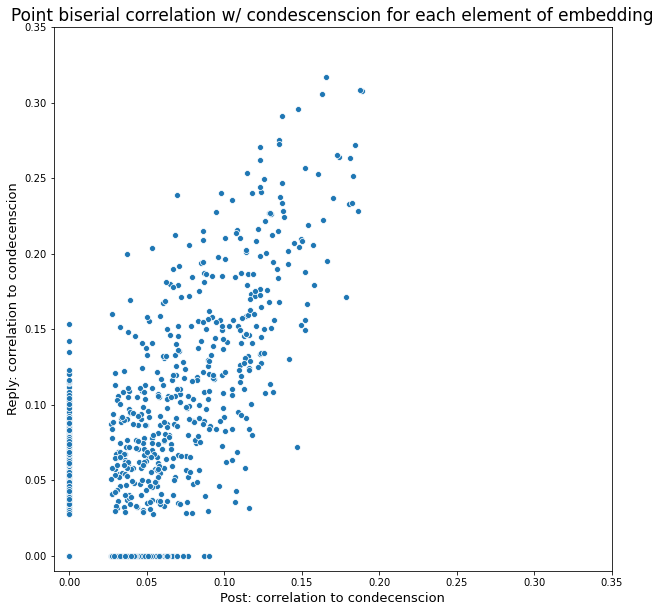

In [8]:
plt.figure(figsize = (10,10))

sns.scatterplot(biserial_correlations["post_corr"], biserial_correlations["reply_corr"])

#sns.distplot(biserial_correlations["post_corr"], label = "post")
#sns.distplot(biserial_correlations["reply_corr"], label = "reply")
plt.title("Point biserial correlation w/ condescenscion for each element of embedding", fontsize=17)
plt.xlim(-0.01, 0.35)
plt.ylim(-0.01, 0.35)
plt.xlabel("Post: correlation to condecenscion", fontsize=13)
plt.ylabel("Reply: correlation to condecenscion", fontsize = 13);

This is pretty promising, we can see that there is clearly a linear-ish pattern.

Note that the elements exactly on the x or y axis are there because if the p value was > 0.05 I just set the correlation to zero.  This is what is creating that weird pattern.

We can also see that the slope is about 2 so posts that are condescending have replies that are twice as condescending.

# Logistic model using embeddings <a id='logistic_model'></a>
I can also try using these embeddings to create a model and see how accurate it is. I will jump straight to using the post + reply since we already figured out that the post alone isn't as good.

In [14]:
# split the data into train and validation
X_train, X_val, y_train, y_val = train_test_split(pd.concat([post_embeddings_df, reply_embeddings_df], axis = 1),
                                                  cond_df["label"])

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

In [107]:
# just use grid search

grid_params = {"C" : [1, 0.1, 0.001],
               "l1_ratio" : [0, 0.25, 0.5, 0.7, 1]}

gridsearcher = GridSearchCV(LogisticRegression(penalty="elasticnet",
                                               solver="saga",
                                               max_iter=1000),
                            param_grid= grid_params,
                            n_jobs=-1,
                            cv = 4, 
                            verbose = 1)

In [108]:
# this takes longer than I expected, I guess there's 1400 columns
gridsearcher.fit(X_train, y_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.9min finished


GridSearchCV(cv=4,
             estimator=LogisticRegression(max_iter=1000, penalty='elasticnet',
                                          solver='saga'),
             n_jobs=-1,
             param_grid={'C': [1, 0.1, 0.001],
                         'l1_ratio': [0, 0.25, 0.5, 0.7, 1]},
             verbose=1)

In [109]:
gridsearcher.best_score_

0.7652351418695571

In [111]:
sentence_logistic_model = gridsearcher.best_estimator_

val_predictions = sentence_logistic_model.predict(X_val)

print("Accuracy")
print(accuracy_score(y_val, val_predictions))

print("\nAUC ROC")
print(roc_auc_score(y_val, val_predictions))

Accuracy
0.782642089093702

AUC ROC
0.7825761723174508


- Model is generalizing well, and is quite accurate
- The topic is indeed a good way to predict condescenscion so our earlier hypothesis was correct.
- It's possible that a better model (ie not logistic regression) would work here but first I want to see something

# PCA visualization <a id='pca1'></a>
Since we showed that changes in the topic of the conversation can be used to predict whether someone is condescending, maybe we can plot this change.

I will use PCA to convert this into a few axes.

In [112]:
from sklearn.decomposition import PCA

In [117]:
# PCA for post and reply separately
post_pca = PCA()
reply_pca = PCA()

post_pca.fit(post_embeddings_df)
reply_pca.fit(reply_embeddings_df)

PCA()

In [118]:
# Apply PCA to post and reply separately
post_pcad_df = pd.DataFrame(post_pca.transform(post_embeddings_df))
reply_pcad_df = pd.DataFrame(reply_pca.transform(reply_embeddings_df))

In [127]:
# take a look at the explained variances of each of the columns for the posts
post_pca.explained_variance_ratio_[0:10]

array([0.14669622, 0.06291341, 0.04517825, 0.03756086, 0.03504482,
       0.02963036, 0.02394394, 0.02027586, 0.01883388, 0.01716673])

In [128]:
# same for reply
reply_pca.explained_variance_ratio_[0:10]

array([0.20173428, 0.06625301, 0.04432802, 0.03418084, 0.03118195,
       0.02693824, 0.0215321 , 0.01973202, 0.01758516, 0.01597145])

In [120]:
post_pcad_df.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,2.861733,-0.194352,-1.412753,1.210380,0.266820,0.421296,-0.157151,0.041808,-0.689479,-0.007716,...,0.054845,-0.028989,-0.049007,-0.071837,-0.015149,-0.019826,-0.014995,-0.011199,-0.012286,-1.474446e-07
1,-2.572767,-0.934328,2.220799,-1.683486,-0.135079,-0.302869,1.888046,0.420747,0.535518,-0.755606,...,0.005663,-0.035681,-0.006123,0.035430,-0.038336,-0.004341,0.028008,0.004861,-0.001841,1.978662e-07
2,-0.093295,1.510770,2.025430,-1.039319,2.237656,0.585548,-0.540680,1.206087,0.619857,0.881731,...,-0.004768,-0.051037,-0.027303,-0.017490,-0.019503,-0.024695,-0.003188,0.038936,-0.018153,-6.121039e-07
3,1.480494,-1.249028,-1.011984,0.858592,-0.843566,0.060221,-0.639021,-0.612676,0.503390,0.150127,...,0.014112,0.015837,-0.028025,-0.039690,0.035004,0.041260,-0.044692,-0.031337,0.003940,-7.523908e-08
4,-1.633386,-1.738354,1.839165,1.680530,-1.557272,-0.176160,-0.538075,0.538302,0.658189,0.181335,...,0.029544,-0.024965,-0.043501,-0.021324,0.044024,-0.028918,-0.007998,-0.022336,-0.003970,-2.480452e-07


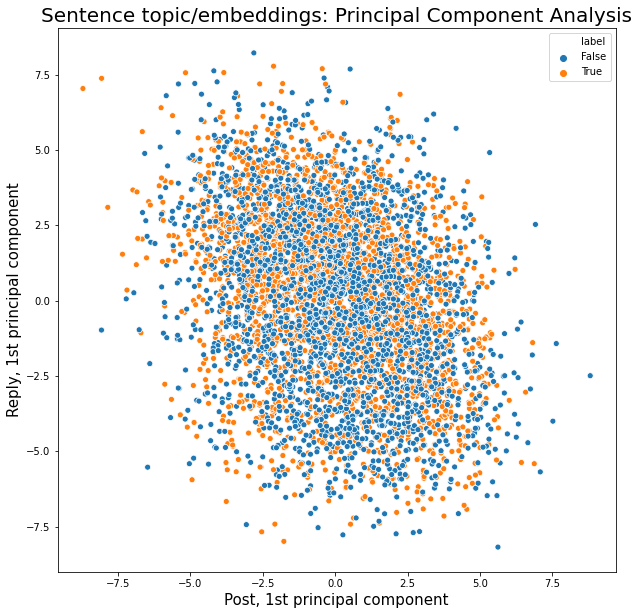

In [126]:
# Plot
plt.figure(figsize=(10,10))
sns.scatterplot(x = post_pcad_df.iloc[:, 0], #first principal component for posts
                y = reply_pcad_df.iloc[:, 0], #first principal component for replies
                hue= cond_df["label"])
plt.xlabel("Post, 1st principal component", fontsize = 15)
plt.ylabel("Reply, 1st principal component", fontsize = 15)
plt.title("Sentence topic/embeddings: Principal Component Analysis", fontsize = 20);

Unfortunately we can't really see the difference.

From the explained variance ratios, we can see that the 1st principal component only makes up 14% of the difference for the post, and 20% for the reply, so maybe I should have expected this.

# Cosine Similarity <a id='cosine'></a>
To be honest I should really have thought of this earlier but if we want to plot the change in topic, why not just find the difference between the two vectors?

Again this is EDA so I'm not going to split the data.


I will use cosine similarity, it's normally used in other areas so I don't know if it's applicable. Maybe it's not really applicable but I'm curious so just try it anyway. I looked at the equation and it seems to make sense here.

In [116]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial

In [117]:
def cosine_sim(df1, df2):
    
    results = []
    
    for i in range(df1.shape[0]):
        results.append(1 - spatial.distance.cosine(df1.iloc[i,:], df2.iloc[i,:]))
    return results

In [118]:
cosine_similarities = cosine_sim(post_embeddings_df, reply_embeddings_df)

In [119]:
# plot the cosine similarities for condescending vs non-condescending posts:
cosine_sim_df = pd.DataFrame([list(cond_df["label"]), cosine_similarities]).transpose()
cosine_sim_df.columns = ["label", "cosine_similarity"]
cosine_sim_df.shape

(5208, 2)

In [120]:
cosine_sim_df.head(2)

,label,cosine_similarity
0,True,0.832478
1,True,0.874723


In [ ]:
cosine_sim_df["cosine_similarity"]

Text(0.5, 1.0, 'Cosine similarity of embeddings, between post and reply')

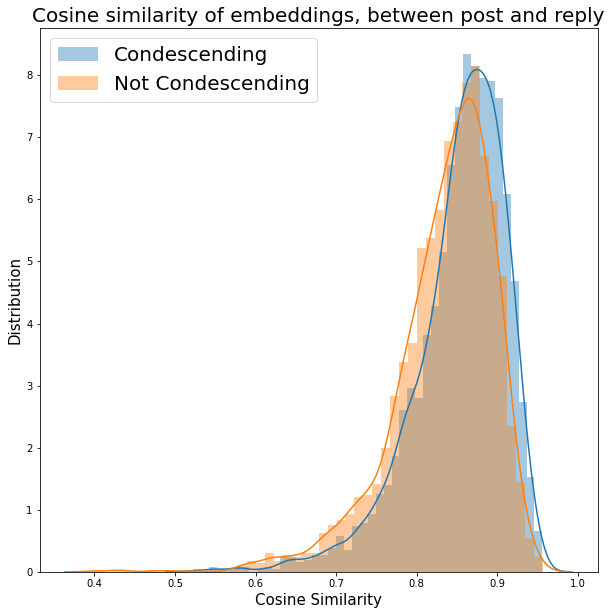

In [41]:
# make a plot
plt.figure(figsize=(10,10))
sns.distplot(cosine_sim_df[cosine_sim_df["label"] == True]["cosine_similarity"], label = "Condescending")

sns.distplot(cosine_sim_df[cosine_sim_df["label"] == False]["cosine_similarity"], label = "Not Condescending")
plt.legend(fontsize=20)
plt.xlabel("Cosine Similarity", fontsize = 15)
plt.ylabel("Distribution", fontsize=15)
plt.title("Cosine similarity of embeddings, between post and reply", fontsize = 20)

We can see that there is a difference although it's not that big.

In [56]:
# calculate the correlation again
pointbiserialr(cosine_sim_df["label"], cosine_sim_df["cosine_similarity"])

PointbiserialrResult(correlation=0.1538435816180983, pvalue=5.966840602653353e-29)

There is a statistically significant difference since p-value is small.

So from this we can see that condescending posts cause the reply to change topic. Although mostly I just did this to make a graph that clearly shows the differences.

# Clustering <a id='clustering'></a>
Earlier, I mentioned that even though BERT was able to determine the embedding of a block of text, it didn't tell us what the embeddings actually mean. Here I will try to figure this out.

Earlier, we saw that there were 2 kinds of responses to a condescending post: strong language and calling out the original post (e.g. "that comment was so __"). Maybe I can use unsupervised learning to see these 2 categories.

Also, maybe there are actually more (or less?) groups, so I will try some methods to identify clusters. After identifying the clusters I can then print the text out and see what patterns there are.

I only want to do this on the condescending posts. Since the topics of the non condescending posts will be all over the place and don't provide any info.

In [31]:
# filter only the posts that are condescending
only_cond_post_embeddings = post_embeddings_df[cond_df["label"] == True]
only_cond_reply_embeddings = reply_embeddings_df[cond_df["label"] == True]

In [32]:
from sklearn.cluster import KMeans

In [33]:
# try a buncha different k values and plot the inertia using the elbow method

num_clusters = list(range(2,40, 2))
inertias = []

for i in num_clusters:
    topic_clustering_kmeans = KMeans(n_clusters=i)
    
    # cluster the post AND the reply topics together.
    topic_clustering_kmeans.fit(pd.concat([only_cond_post_embeddings,
                                           only_cond_reply_embeddings], axis = 1))
    
    # get the inertia
    inertias.append(topic_clustering_kmeans.inertia_)

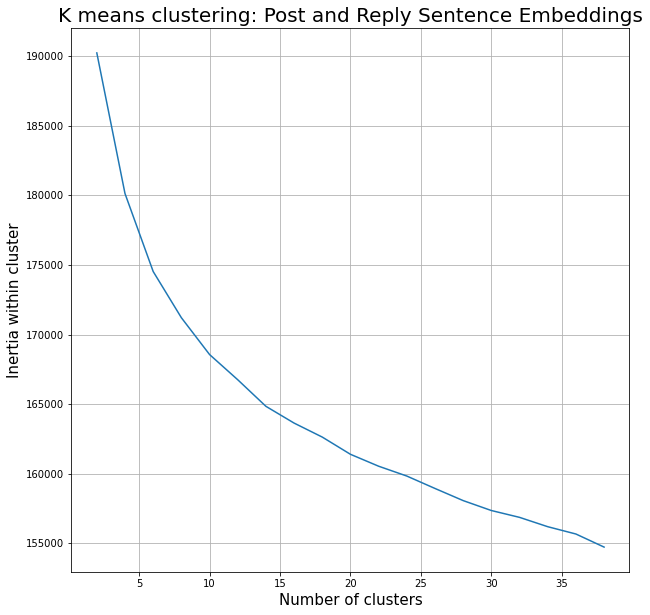

In [34]:
plt.figure(figsize = (10,10))
sns.lineplot(num_clusters, inertias)
plt.grid()
plt.xlabel("Number of clusters", fontsize = 15)
plt.ylabel("Inertia within cluster", fontsize = 15)
plt.title("K means clustering: Post and Reply Sentence Embeddings", fontsize = 20);

I don't see any elbows so this isn't looking good. Of course if there actually are only 2 categories, then the elbow method wouldn't work. So either
- There really are 2 categories (unlikely?)
- Condescending posts can't be neatly classified into any number of categories since everything is slightly different (more likely).

If I just assume there are 2 categories we can see what happens. Split the condescending posts into 2 categories via clustering the topic/embeddings.

In [161]:
two_clusters = KMeans(2)

categories = two_clusters.fit_transform(pd.concat([only_cond_post_embeddings,
                                                   only_cond_reply_embeddings], axis = 1))

categories

array([[11.84713225,  8.20649148],
       [ 8.69740629, 10.80248497],
       [ 9.60563765,  6.98744998],
       ...,
       [ 8.37471145, 10.68638861],
       [ 6.84020585,  8.90878207],
       [ 8.16185369,  8.18374615]])

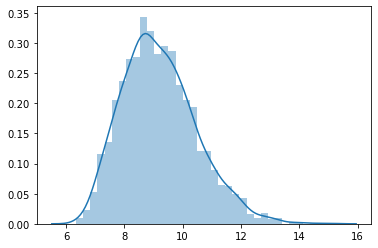

In [171]:
# Plot the distribution of the first category
sns.distplot(categories[:,0])

We can see that the K means cluster didn't find 2 categories since there is just one big lump in the middle. This means that there weren't 2 categories.

## Clustering with individual words
Basically, just do the same thing as above just with the words themselves. I figured since I can't find any pattern in the sentence embeddings it's better to just check by looking directly at the words.

Use count vectorizer for this.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

In [11]:
condescending_posts_only = cond_df[cond_df["label"] == True]

In [25]:
# vectorize

def vectorize_words(series):
    # I only went with 500 to avoid too many features
    my_vectorizer = CountVectorizer(stop_words = ENGLISH_STOP_WORDS, min_df=10, max_features = 500)

    df_vectorized = my_vectorizer.fit_transform(series)
    return pd.DataFrame(df_vectorized.todense(),
                        columns=my_vectorizer.get_feature_names())

post_words_vectorized = vectorize_words(cond_df["cleaned_post"])
reply_words_vectorized = vectorize_words(cond_df["cleaned_reply"])

Use elbow method again.

In [29]:
%%time
all_words_vectorized = pd.concat([post_words_vectorized, reply_words_vectorized], axis = 1)

# note: I ran it with a larger range but the elbow is here
k_vals = list(range(2, 10, 1))
inertias = []

for i in k_vals:
    kmeans_i = KMeans(i)
    
    kmeans_i.fit(all_words_vectorized)
    
    inertias.append(kmeans_i.inertia_)
    
print("done")

done
Wall time: 13.1 s


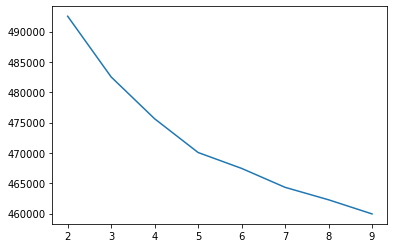

In [30]:
sns.lineplot(k_vals, inertias)

I guess there is just one big cluster. This means that I was wrong earlier and condescenscion doesn't elicit 2 (or more) types of responses, just one big one.

# More models <a id='more_models'></a>
At this point I'm not really sure what else I can analyze so maybe it's time to just try different models. First let's try a random forest - it's fast and usually works ok.

However, in addition I will add in a new column, the cosine similarity of the embeddings between post and reply. We also found out that condescending posts have condescending replies however this doesn't really help since we are already putting the reply in, so that doesn't get a new column.

In [122]:
cosine_sim_df.head(3)

,label,cosine_similarity
0,True,0.832478
1,True,0.874723
2,False,0.903615


In [123]:
X_train, X_val, y_train, y_val = train_test_split(pd.concat([post_embeddings_df,
                                                             reply_embeddings_df,
                                                             cosine_sim_df["cosine_similarity"]],
                                                            axis = 1),
                                                  cond_df["label"])

In [124]:
# might as well try a random forest, it's fast and captures nonlinear relationships too
from sklearn.ensemble import RandomForestClassifier

In [125]:
%%time
forest = RandomForestClassifier()

forest.fit(X_train, y_train)

Wall time: 8.98 s


RandomForestClassifier()

In [126]:
val_predictions_forest = forest.predict(X_val)

In [127]:
accuracy_score(y_val, val_predictions_forest)

0.716589861751152

In [128]:
accuracy_score(y_train, forest.predict(X_train))

1.0

In [129]:
# It is overfitting so try some parameters
forest_params = {"min_samples_split" : [2, 5, 10],
                 "min_samples_leaf" : [1, 2, 5]}

forest_gridsearch = GridSearchCV(forest,
                                 param_grid= forest_params,
                                 n_jobs = -1,
                                 cv = 5,
                                 verbose = 1)

In [130]:
forest_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   44.6s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]},
             verbose=1)

In [131]:
forest_gridsearch.best_score_

0.7421958863153344

In [132]:
val_predictions = forest_gridsearch.predict(X_val)

In [133]:
roc_auc_score(y_val, val_predictions)

0.730140672205438

In [134]:
forest_gridsearch.best_estimator_

RandomForestClassifier(min_samples_leaf=5, min_samples_split=10)

We can see that this model isn't better. Actually, logistic regression worked a bit better although it might just come down to tuning hyperparams.

Next, try a neural net

In [139]:
from sklearn.decomposition import PCA

In [136]:
%%time
my_pca = PCA()

my_pca.fit(X_train)

Wall time: 3.26 s


PCA()

In [140]:
for i in range(len(my_pca.explained_variance_ratio_)):
    if my_pca.explained_variance_ratio_.cumsum()[i] > 0.8:
        print(i)
        break

164


We need about 363 of the columns to have 90% explained variance but only about 160 for 80%. I'll just try 80% and see what happens.

In [141]:
# Get PCA-d versions of X_train and X_test

X_train_pca = my_pca.transform(X_train)[:, :170]
X_val_pca = my_pca.transform(X_val)[:, :170]

In [142]:
X_train_pca.shape

(3906, 170)

In [143]:
# import keras things
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import AUC
from keras import regularizers
from keras.callbacks import EarlyStopping

In [144]:
# create a neural net which can predict

keras_model = Sequential()

input_cols = 170

#input layer
keras_model.add(Dense(input_cols,
                      input_shape=(input_cols,),
                      activation="relu",
                      kernel_regularizer = regularizers.l2(0.01)))

#keras_model.add(Dense(15, activation="relu"))

# output is 1 node with softmax
keras_model.add(Dense(1, activation="sigmoid"))

In [145]:
# compile
keras_model.compile(loss="binary_crossentropy",
                    optimizer="adam",
                    metrics=[AUC()])

In [146]:
early_stop = EarlyStopping(monitor="val_loss", patience=5)

In [147]:
# run
history = keras_model.fit(X_train_pca,
                          y_train,
                          validation_data=(X_val_pca, y_val),
                          batch_size=8,
                          epochs=10, callbacks=[early_stop])

Epoch 1/10
489/489 [==============================] - 1s 1ms/step - loss: 0.9948 - auc_10: 0.8091 - val_loss: 0.6486 - val_auc_10: 0.8252
Epoch 2/10
489/489 [==============================] - 0s 891us/step - loss: 0.5740 - auc_10: 0.8515 - val_loss: 0.5852 - val_auc_10: 0.8297
Epoch 3/10
489/489 [==============================] - 0s 861us/step - loss: 0.5423 - auc_10: 0.8553 - val_loss: 0.5599 - val_auc_10: 0.8389
Epoch 4/10
489/489 [==============================] - 0s 861us/step - loss: 0.5282 - auc_10: 0.8603 - val_loss: 0.5706 - val_auc_10: 0.8297
Epoch 5/10
489/489 [==============================] - 0s 855us/step - loss: 0.5243 - auc_10: 0.8615 - val_loss: 0.5615 - val_auc_10: 0.8363
Epoch 6/10
489/489 [==============================] - 0s 842us/step - loss: 0.5166 - auc_10: 0.8675 - val_loss: 0.5570 - val_auc_10: 0.8369
Epoch 7/10
489/489 [==============================] - 0s 846us/step - loss: 0.5097 - auc_10: 0.8718 - val_loss: 0.5671 - val_auc_10: 0.8347
Epoch 8/10
489/489 [==

In [151]:
val_predictions = keras_model.predict(X_val_pca)

In [152]:
# convert to 1 or 0
val_predictions = [1 if i > 0.5 else 0 for i in val_predictions]

In [153]:
# get the auc roc
roc_auc_score(y_val, val_predictions)

0.7655872356495468

It seems that using a logistic regression is better by a little bit. A neural net is obviously going to outperform a logistic regression if tuned properly but I can't seem to find the right parameters. I tried doing various things like changing the number of PCA columns/different layers in the neural net but nothing really helped. Anyway the difference isn't that large.

Since we are just predicting by looking at the sentence-level embeddings this method probably isn't amazing.

# What next?
I will try using BERT to see if I can predict posts that are condescending by only looking at the post column. Please see the next notebook for this.